In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [3]:
# Assuming that the dataset has a column named 'junction'.
# If the column name is different (e.g., 'Junction'), adjust accordingly.
df_junction1 = df[df['Junction'] == 1].reset_index(drop=True)
print("Filtered data shape (junction 1 only):", df_junction1.shape)


Filtered data shape (junction 1 only): (14592, 4)


In [4]:
import numpy as np

# Load the indices from the saved text files
train_idx = np.loadtxt("train_order_idx.txt", dtype=int)
val_idx   = np.loadtxt("val_order_idx.txt", dtype=int)
test_idx  = np.loadtxt("test_order_idx.txt", dtype=int)

# Re-create the training, validation, and test DataFrames from df_junction1
train_data = df_junction1.iloc[train_idx].reset_index(drop=True)
val_data   = df_junction1.iloc[val_idx].reset_index(drop=True)
test_data  = df_junction1.iloc[test_idx].reset_index(drop=True)

print("Train, Val, and Test sets created:")
print(" - Train data shape:", train_data.shape)
print(" - Validation data shape:", val_data.shape)
print(" - Test data shape:", test_data.shape)


Train, Val, and Test sets created:
 - Train data shape: (10214, 4)
 - Validation data shape: (1459, 4)
 - Test data shape: (2919, 4)


In [5]:
import pandas as pd

# Convert the DateTime column to datetime, if not already done
for d in [train_data, val_data, test_data]:
    d['DateTime'] = pd.to_datetime(d['DateTime'])

# Define the target column and feature columns
target_col = 'Vehicles'
# Remove target and DateTime columns from features list
feature_cols = [col for col in train_data.columns if col not in [target_col, 'DateTime']]

# Separate features and target for each split
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# No scaling at this stage - we'll handle specific scaling later
print("Features and targets separated without scaling.")

Features and targets separated without scaling.



Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Device name: NVIDIA GeForce GTX 1050 Ti
Starting PatchTST training...
  -> Validation loss improved to 0.317990. Saving model.
Epoch 1/50 - Train Loss: 0.351232 - Val Loss: 0.317990 - Time: 7.15s
  -> Validation loss improved to 0.268952. Saving model.
Epoch 2/50 - Train Loss: 0.115388 - Val Loss: 0.268952 - Time: 6.31s
  -> Validation loss improved to 0.248393. Saving model.
Epoch 3/50 - Train Loss: 0.099795 - Val Loss: 0.248393 - Time: 6.06s
  -> Validation loss improved to 0.228794. Saving model.
Epoch 4/50 - Train Loss: 0.093570 - Val Loss: 0.228794 - Time: 6.18s
  -> Validation loss improved to 0.228730. Saving model.
Epoch 5/50 - Train Loss: 0.089028 - Val Loss: 0.228730 - Time: 6.13s
Epoch 6/50 - Train Loss: 0.085573 - Val Loss: 0.230973 - Time: 6.08s
Epoch 7/50 - Train Loss: 0.083113 - Val Loss: 0.229052 - Time: 6.20s
  -> Validation loss improved to 0.224482. Saving model.
Epoch 8/50 - Train Loss: 0.080642 - V

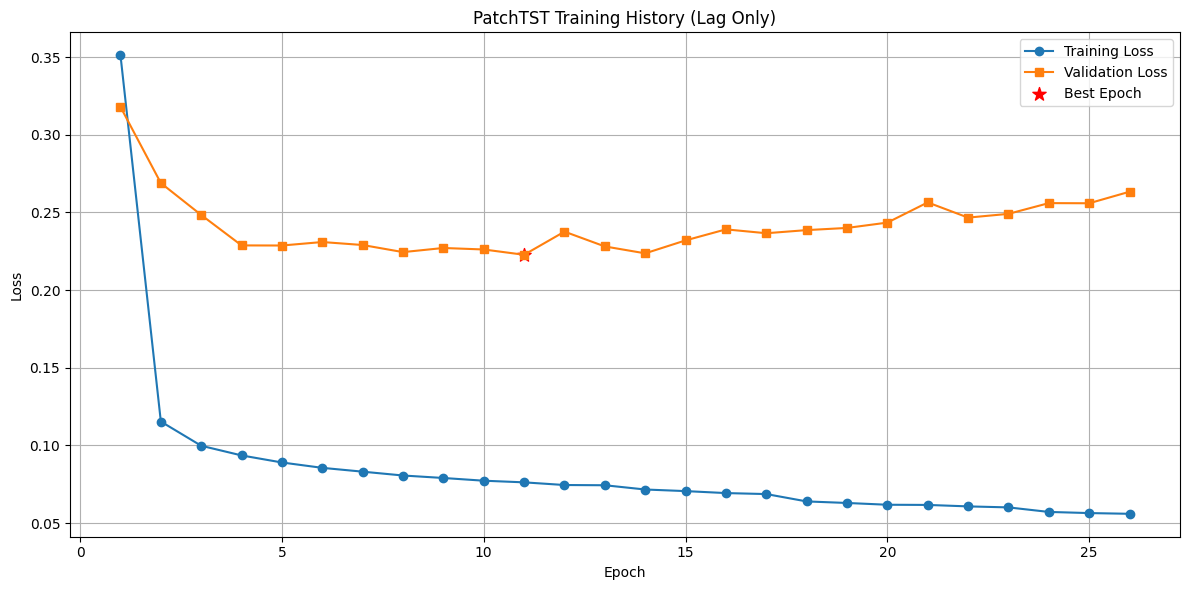


Loading best model from PatchTST_lag_only_model_24h for evaluation...
Best model loaded successfully.


In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from transformers import PatchTSTConfig, PatchTSTForPrediction
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Enhanced temporal features (Function kept for sorting, but features not used as input) ===
def extract_enhanced_datetime_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_workday'] = (~df['is_weekend']).astype(int)
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = ((df['morning_rush'] | df['evening_rush']) & df['is_workday']).astype(int)
    return df

context_length = 168
prediction_length = 24

train_data_sorted = extract_enhanced_datetime_features(train_data.sort_values('DateTime').reset_index(drop=True))
val_data_sorted = extract_enhanced_datetime_features(val_data.sort_values('DateTime').reset_index(drop=True))
test_data_sorted = extract_enhanced_datetime_features(test_data.sort_values('DateTime').reset_index(drop=True))

scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(train_data_sorted)))
scaler.fit(train_data_sorted['Vehicles'].values.reshape(-1, 1))

train_scaled = scaler.transform(train_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
val_scaled = scaler.transform(val_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()

def prepare_transformer_data(values, context_length, prediction_length):
    past_values, future_values, past_observed_mask = [], [], []
    total_len_needed = context_length + prediction_length
    for i in range(len(values) - total_len_needed + 1):
        past_values.append(values[i : i + context_length])
        future_values.append(values[i + context_length : i + total_len_needed])
        past_observed_mask.append(np.ones(context_length, dtype=bool))
    return (
        np.array(past_values),
        np.array(past_observed_mask),
        np.array(future_values)
    )

train_past_vals, train_mask, train_future_vals = prepare_transformer_data(
    train_scaled, context_length, prediction_length
)
val_past_vals, val_mask, val_future_vals = prepare_transformer_data(
    val_scaled, context_length, prediction_length
)
test_past_vals, test_mask, test_future_vals = prepare_transformer_data(
    test_scaled, context_length, prediction_length
)

# PatchTST expects past_values in shape [batch_size, seq_length, num_input_channels]
train_past_values_tensor = torch.tensor(train_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
train_future_values_tensor = torch.tensor(train_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
train_observed_mask_tensor = torch.tensor(train_mask, dtype=torch.bool).unsqueeze(-1).to(device)

val_past_values_tensor = torch.tensor(val_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
val_future_values_tensor = torch.tensor(val_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
val_observed_mask_tensor = torch.tensor(val_mask, dtype=torch.bool).unsqueeze(-1).to(device)

test_past_values_tensor = torch.tensor(test_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
test_future_values_tensor = torch.tensor(test_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
test_observed_mask_tensor = torch.tensor(test_mask, dtype=torch.bool).unsqueeze(-1).to(device)

train_dataset = TensorDataset(train_past_values_tensor, train_observed_mask_tensor, train_future_values_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# === PatchTST Config ===
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,  # <--- Ensure this matches above
    patch_length=12,
    patch_stride=12,
    num_input_channels=1,
    d_model=256,
    num_hidden_layers=8,
    num_attention_heads=4,
    ffn_dim=512,
    dropout=0.2,
    norm_type="layernorm",
    scaling="std",
    loss="mse",
    head_dropout=0.2
)

model = PatchTSTForPrediction(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Starting PatchTST training...")
best_val_loss = float('inf')
patience = 15
patience_counter = 0
epochs = 50
train_losses, val_losses, epoch_times = [], [], []
model_name = "PatchTST_lag_only_model_24h"

for epoch in range(epochs):
    model.train()
    epoch_start = time.time()
    epoch_loss = 0

    for past_batch, mask_batch, future_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            past_values=past_batch,
            past_observed_mask=mask_batch,
            future_values=future_batch
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item() * past_batch.size(0)

    avg_train_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(
            past_values=val_past_values_tensor,
            past_observed_mask=val_observed_mask_tensor,
            future_values=val_future_values_tensor
        )
        val_loss = val_outputs.loss.item()
        val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained(model_name)
        print(f"  -> Validation loss improved to {best_val_loss:.6f}. Saving model.")
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f} - Time: {epoch_time:.2f}s")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\nTraining completed in {len(train_losses)} epochs")
if val_losses:
    best_epoch_idx = val_losses.index(min(val_losses))
    print(f"Best validation loss: {min(val_losses):.6f} at epoch {best_epoch_idx + 1}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")
else:
    print("No validation losses recorded.")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
if val_losses:
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='s')
    if 'best_epoch_idx' in locals():
        plt.scatter(best_epoch_idx + 1, min(val_losses), c='red', s=100, label='Best Epoch', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PatchTST Training History (Lag Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nLoading best model from {model_name} for evaluation...")
import os
if os.path.exists(model_name):
    model = PatchTSTForPrediction.from_pretrained(model_name).to(device)
    print("Best model loaded successfully.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch.")

Loaded best model from PatchTST_lag_only_model for evaluation.
Generating predictions on the test set using forward pass...
Shape of scaled predictions: (2728,)
Shape of original predictions: (2728,)
Shape of original targets: (65472,)

PatchTST Last 24h RMSE: 12.99
PatchTST Last 24h MAE: 10.01
PatchTST Last 24h R2 Score: 0.62


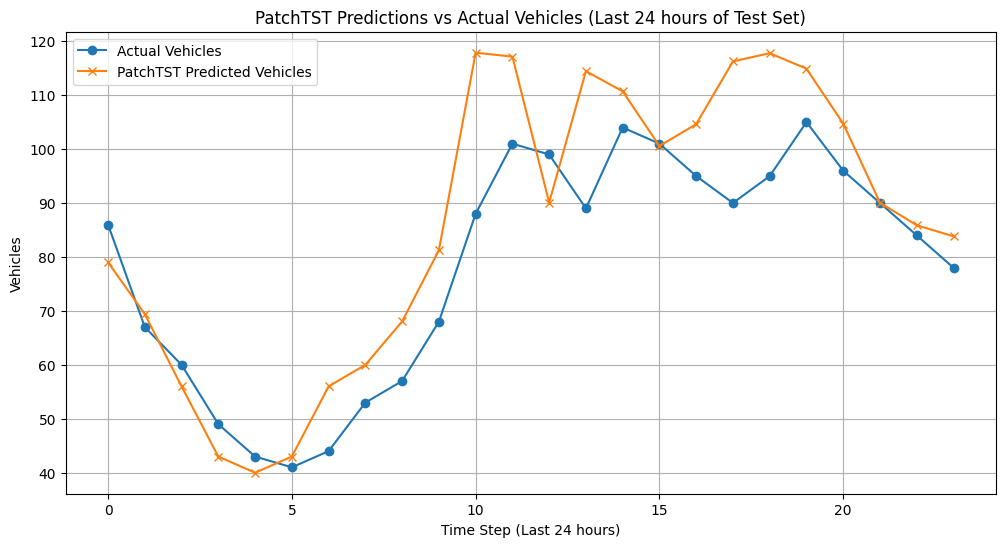

In [7]:
# === Evaluate PatchTST Model ===
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

# Ensure the best model is loaded (or use the last trained one if save failed)
model_name = "PatchTST_lag_only_model"
if os.path.exists(model_name):
    model = PatchTSTForPrediction.from_pretrained(model_name).to(device)
    print(f"Loaded best model from {model_name} for evaluation.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch for evaluation.")
    model.to(device)

# Set model to evaluation mode
model.eval()

# Store predictions
all_preds_scaled = []

# Predict on the test set using standard forward pass
with torch.no_grad():
    # PatchTST expects mask as past_observed_mask
    test_dataset_eval = TensorDataset(test_past_values_tensor, test_observed_mask_tensor)
    test_loader_eval = DataLoader(test_dataset_eval, batch_size=128, shuffle=False)

    print("Generating predictions on the test set using forward pass...")
    for past_batch, mask_batch in test_loader_eval:
        outputs = model(
            past_values=past_batch,
            past_observed_mask=mask_batch
            # No future_values needed for prediction
        )
        # Shape is [batch_size, prediction_length, num_input_channels]
        preds = outputs.prediction_outputs.squeeze().cpu().numpy()
        all_preds_scaled.append(preds)

# Concatenate predictions from all batches
patchtst_test_pred_scaled = np.concatenate(all_preds_scaled)

# Ensure it's a 1D array if prediction_length was 1
if patchtst_test_pred_scaled.ndim > 1 and patchtst_test_pred_scaled.shape[1] == 1:
    patchtst_test_pred_scaled = patchtst_test_pred_scaled.flatten()
elif patchtst_test_pred_scaled.ndim == 0:
    patchtst_test_pred_scaled = np.array([patchtst_test_pred_scaled.item()])
elif patchtst_test_pred_scaled.ndim != 1:
    print(f"Warning: Unexpected prediction shape after concatenation: {patchtst_test_pred_scaled.shape}. Attempting to flatten.")
    patchtst_test_pred_scaled = patchtst_test_pred_scaled.flatten()

print(f"Shape of scaled predictions: {patchtst_test_pred_scaled.shape}")

# Inverse transform the predictions to get the original scale
patchtst_test_pred_orig = scaler.inverse_transform(patchtst_test_pred_scaled.reshape(-1, 1)).flatten()
patchtst_test_pred_orig = np.clip(patchtst_test_pred_orig, 0, None) # Ensure non-negative predictions

# Get the original actual test targets corresponding to the predictions
y_test_orig = scaler.inverse_transform(test_future_vals.reshape(-1, 1)).flatten()
y_test_orig = np.clip(y_test_orig, 0, None) # Ensure non-negative targets

print(f"Shape of original predictions: {patchtst_test_pred_orig.shape}")
print(f"Shape of original targets: {y_test_orig.shape}")

from sklearn.metrics import r2_score  # <--- ADD THIS LINE

# Only compare the last 24 hours of predictions to the last 24 hours of actuals
last_n = 24  # Use prediction_length if needed

patchtst_test_pred_orig_24h = patchtst_test_pred_orig[-last_n:]
y_test_orig_24h = y_test_orig[-last_n:]

# Calculate RMSE, MAE, and R2 for PatchTST predictions (last 24 hours)
if len(patchtst_test_pred_orig_24h) == len(y_test_orig_24h) and len(y_test_orig_24h) > 0:
    patchtst_rmse_24h = np.sqrt(mean_squared_error(y_test_orig_24h, patchtst_test_pred_orig_24h))
    patchtst_mae_24h = mean_absolute_error(y_test_orig_24h, patchtst_test_pred_orig_24h)
    patchtst_r2_24h = r2_score(y_test_orig_24h, patchtst_test_pred_orig_24h)

    print(f"\nPatchTST Last 24h RMSE: {patchtst_rmse_24h:.2f}")
    print(f"PatchTST Last 24h MAE: {patchtst_mae_24h:.2f}")
    print(f"PatchTST Last 24h R2 Score: {patchtst_r2_24h:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig_24h, label='Actual Vehicles', marker='o')
    plt.plot(patchtst_test_pred_orig_24h, label='PatchTST Predicted Vehicles', marker='x')
    plt.title('PatchTST Predictions vs Actual Vehicles (Last 24 hours of Test Set)')
    plt.xlabel('Time Step (Last 24 hours)')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nCannot calculate metrics or plot: No matching predictions and targets found for the last 24 hours.")

In [12]:
# Calculate RMSE, MAE, and R2 for PatchTST predictions on the last 20% of the dataset

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get the last 20% of the original dataset as ground truth
n_total = len(df_junction1)
n_20 = int(n_total * 0.2)
actual_vehicles = df_junction1['Vehicles'].values[-n_20:]

# Get the last 20% of PatchTST predictions (make sure to align shapes)
pred_vehicles = patchtst_test_pred_orig[-n_20:]
if len(pred_vehicles) != len(actual_vehicles):
    min_len = min(len(pred_vehicles), len(actual_vehicles))
    pred_vehicles = pred_vehicles[:min_len]
    actual_vehicles = actual_vehicles[:min_len]

rmse = np.sqrt(mean_squared_error(actual_vehicles, pred_vehicles))
mae = mean_absolute_error(actual_vehicles, pred_vehicles)
r2 = r2_score(actual_vehicles, pred_vehicles)

print(f"\nPatchTST Last 20% RMSE: {rmse:.2f}")
print(f"PatchTST Last 20% MAE: {mae:.2f}")
print(f"PatchTST Last 20% R2 Score: {r2:.2f}")


PatchTST Last 20% RMSE: 10.96
PatchTST Last 20% MAE: 8.64
PatchTST Last 20% R2 Score: 0.78
